In [130]:
import bs4 as bs
import datetime
#get finance data from yahoo 
#need to use command -- pip install yfinance
import yfinance as yf
import pandas as pd
import requests
import pylab
import numpy as np
import matplotlib.pyplot as plt

from scipy import ndimage 
from scipy.stats import kurtosis, skew
import scipy.cluster.hierarchy as sch
from scipy.spatial.distance import pdist,squareform
from scipy.spatial import distance_matrix 
from sklearn.cluster import AgglomerativeClustering 
from sklearn.cluster import KMeans 
from mpl_toolkits.mplot3d import Axes3D 

In [129]:
resp = requests.get('http://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
soup = bs.BeautifulSoup(resp.text, 'lxml')
table = soup.find('table', {'class': 'wikitable sortable'})
tickers = []
sectors = []
for row in table.findAll('tr')[1:]:
    ticker = row.findAll('td')[0].text
    tickers.append(ticker)
    sector = row.findAll('td')[3].text
    sectors.append(sector)

tickers = [s.replace('\n', '') for s in tickers]
sectors = [s.replace('\n', '') for s in sectors]
start = datetime.datetime(2019,1,1)
end = datetime.datetime(2020,1,1)
data = yf.download(tickers, start=start, end=end)

[*********************100%***********************]  505 of 505 completed

6 Failed downloads:
- BF.B: No data found for this date range, symbol may be delisted
- CARR: Data doesn't exist for startDate = 1546272000, endDate = 1577808000
- LUMN: No data found for this date range, symbol may be delisted
- VNT: Data doesn't exist for startDate = 1546272000, endDate = 1577808000
- OTIS: Data doesn't exist for startDate = 1546272000, endDate = 1577808000
- BRK.B: No data found, symbol may be delisted


In [131]:
#process data, create feature
#drop the stock if more than 5 prices are missing, otherwise replace the missing values with the values in the previous row
data = data.dropna(axis=1,thresh=5)
data = data.fillna(axis=1, method='ffill')
#print(df.isnull().sum())
prices = df

#%%
# Calculate the log returns
log_r = np.log(prices / prices.shift(1))
log_r = log_r.dropna(axis = 0)

# Compute the annualised returns
annual_r = log_r.mean() * 252
annual_r.name = 'annual return log'

# Calculate the covariance matrix
cov_matrix = log_r.cov() * 252
cov_matrix

# Calculate the volatility
var = log_r.var() * 252
Std = np.sqrt(var)
Std.name = 'Std'

#%%

# Calculate Skewness and Kurtosis
index=annual_r.index
Skewness=pd.DataFrame(skew(log_r))
Kurtosis=pd.DataFrame(kurtosis(log_r))

Skewness.set_index(index, inplace=True)
Kurtosis.set_index(index, inplace=True)

Skewness.columns=['Skewness']
Kurtosis.columns=['Kurtosis']


#%%
# Compile the dataset we need

pd_sectors = pd.Series(sectors, index = tickers)
pd_sectors.name = 'sector'

dataset = pd.concat([pd_sectors, annual_r, Std, Skewness, Kurtosis], axis = 1,sort=True)
dataset = dataset.dropna()
dataset.reset_index(level=0, inplace=True)
dataset.columns=['Company', 'sector', 'annual_return_log', 'Std','Skewness','Kurtosis']
dataset

,Company,sector,annual_return_log,Std,Skewness,Kurtosis
0,A,Health Care,0.243257,0.247760,-1.840437,12.761340
1,AAL,Industrials,-0.100616,0.356610,-0.337182,1.643768
2,AAP,Consumer Discretionary,0.018528,0.266139,-0.506610,1.877788
3,AAPL,Information Technology,0.636354,0.262970,-1.128371,8.080885
4,ABBV,Health Care,0.029214,0.282116,-4.132772,38.610585
5,ABC,Health Care,0.152555,0.274349,-0.286581,1.531583
6,ABMD,Health Care,-0.644685,0.536054,-3.885721,32.883261
7,ABT,Health Care,0.199508,0.199360,-0.752111,1.827990
8,ACN,Information Technology,0.413523,0.168519,-0.244617,3.338731
9,ADBE,Information Technology,0.376920,0.238078,-0.151673,1.327801


In [132]:
# Prepare Dataset
industry= dataset.groupby(['sector'])['annual_return_log', 'Std' ].mean()
industry = industry.reset_index()
featureset = industry[['annual_return_log', 'Std']]
feature_mtx = featureset.values 
feature500 = dataset[['annual_return_log','Std']]
feature500_mtx = feature500.values

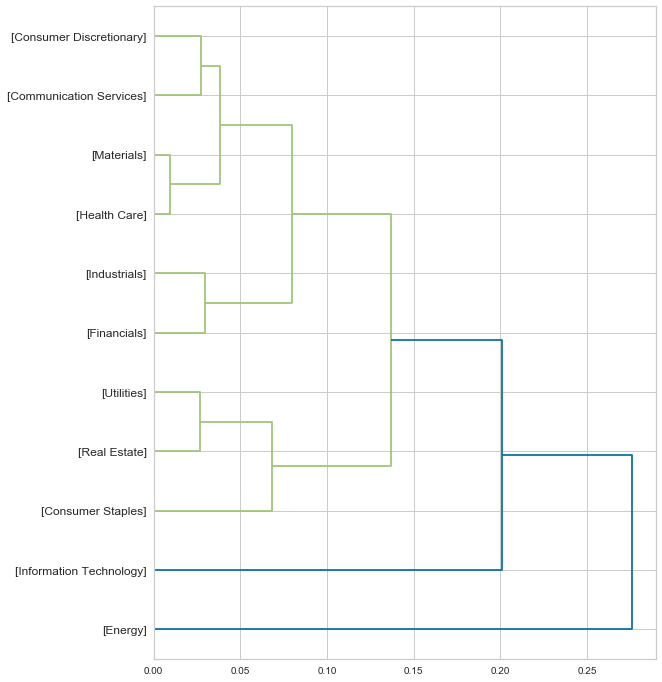

In [133]:
######### Part 1: Hierarchical Clustering

######## Plot1
leng = feature_mtx.shape[0]

D = np.zeros([leng,leng])
for i in range(leng):
    for j in range(leng):
        D[i,j] = scipy.spatial.distance.euclidean(feature_mtx[i], feature_mtx[j])
D = squareform(D)
Z = sch.linkage(D, 'complete')
max_d = 5
clusters = sch.fcluster(Z, max_d, criterion='distance')

#plot the denrogram
fig = pylab.figure(figsize=(9, 12))
def llf(id):
    return '[%s]' % ( (str(industry['sector'][id])) )
dendro = sch.dendrogram(Z,  leaf_label_func=llf, leaf_rotation=0, leaf_font_size =12, orientation = 'right')

plt.savefig('plot 1.png', bbox_inches = 'tight')
plt.show()

Text(0,0.5,'annual return')

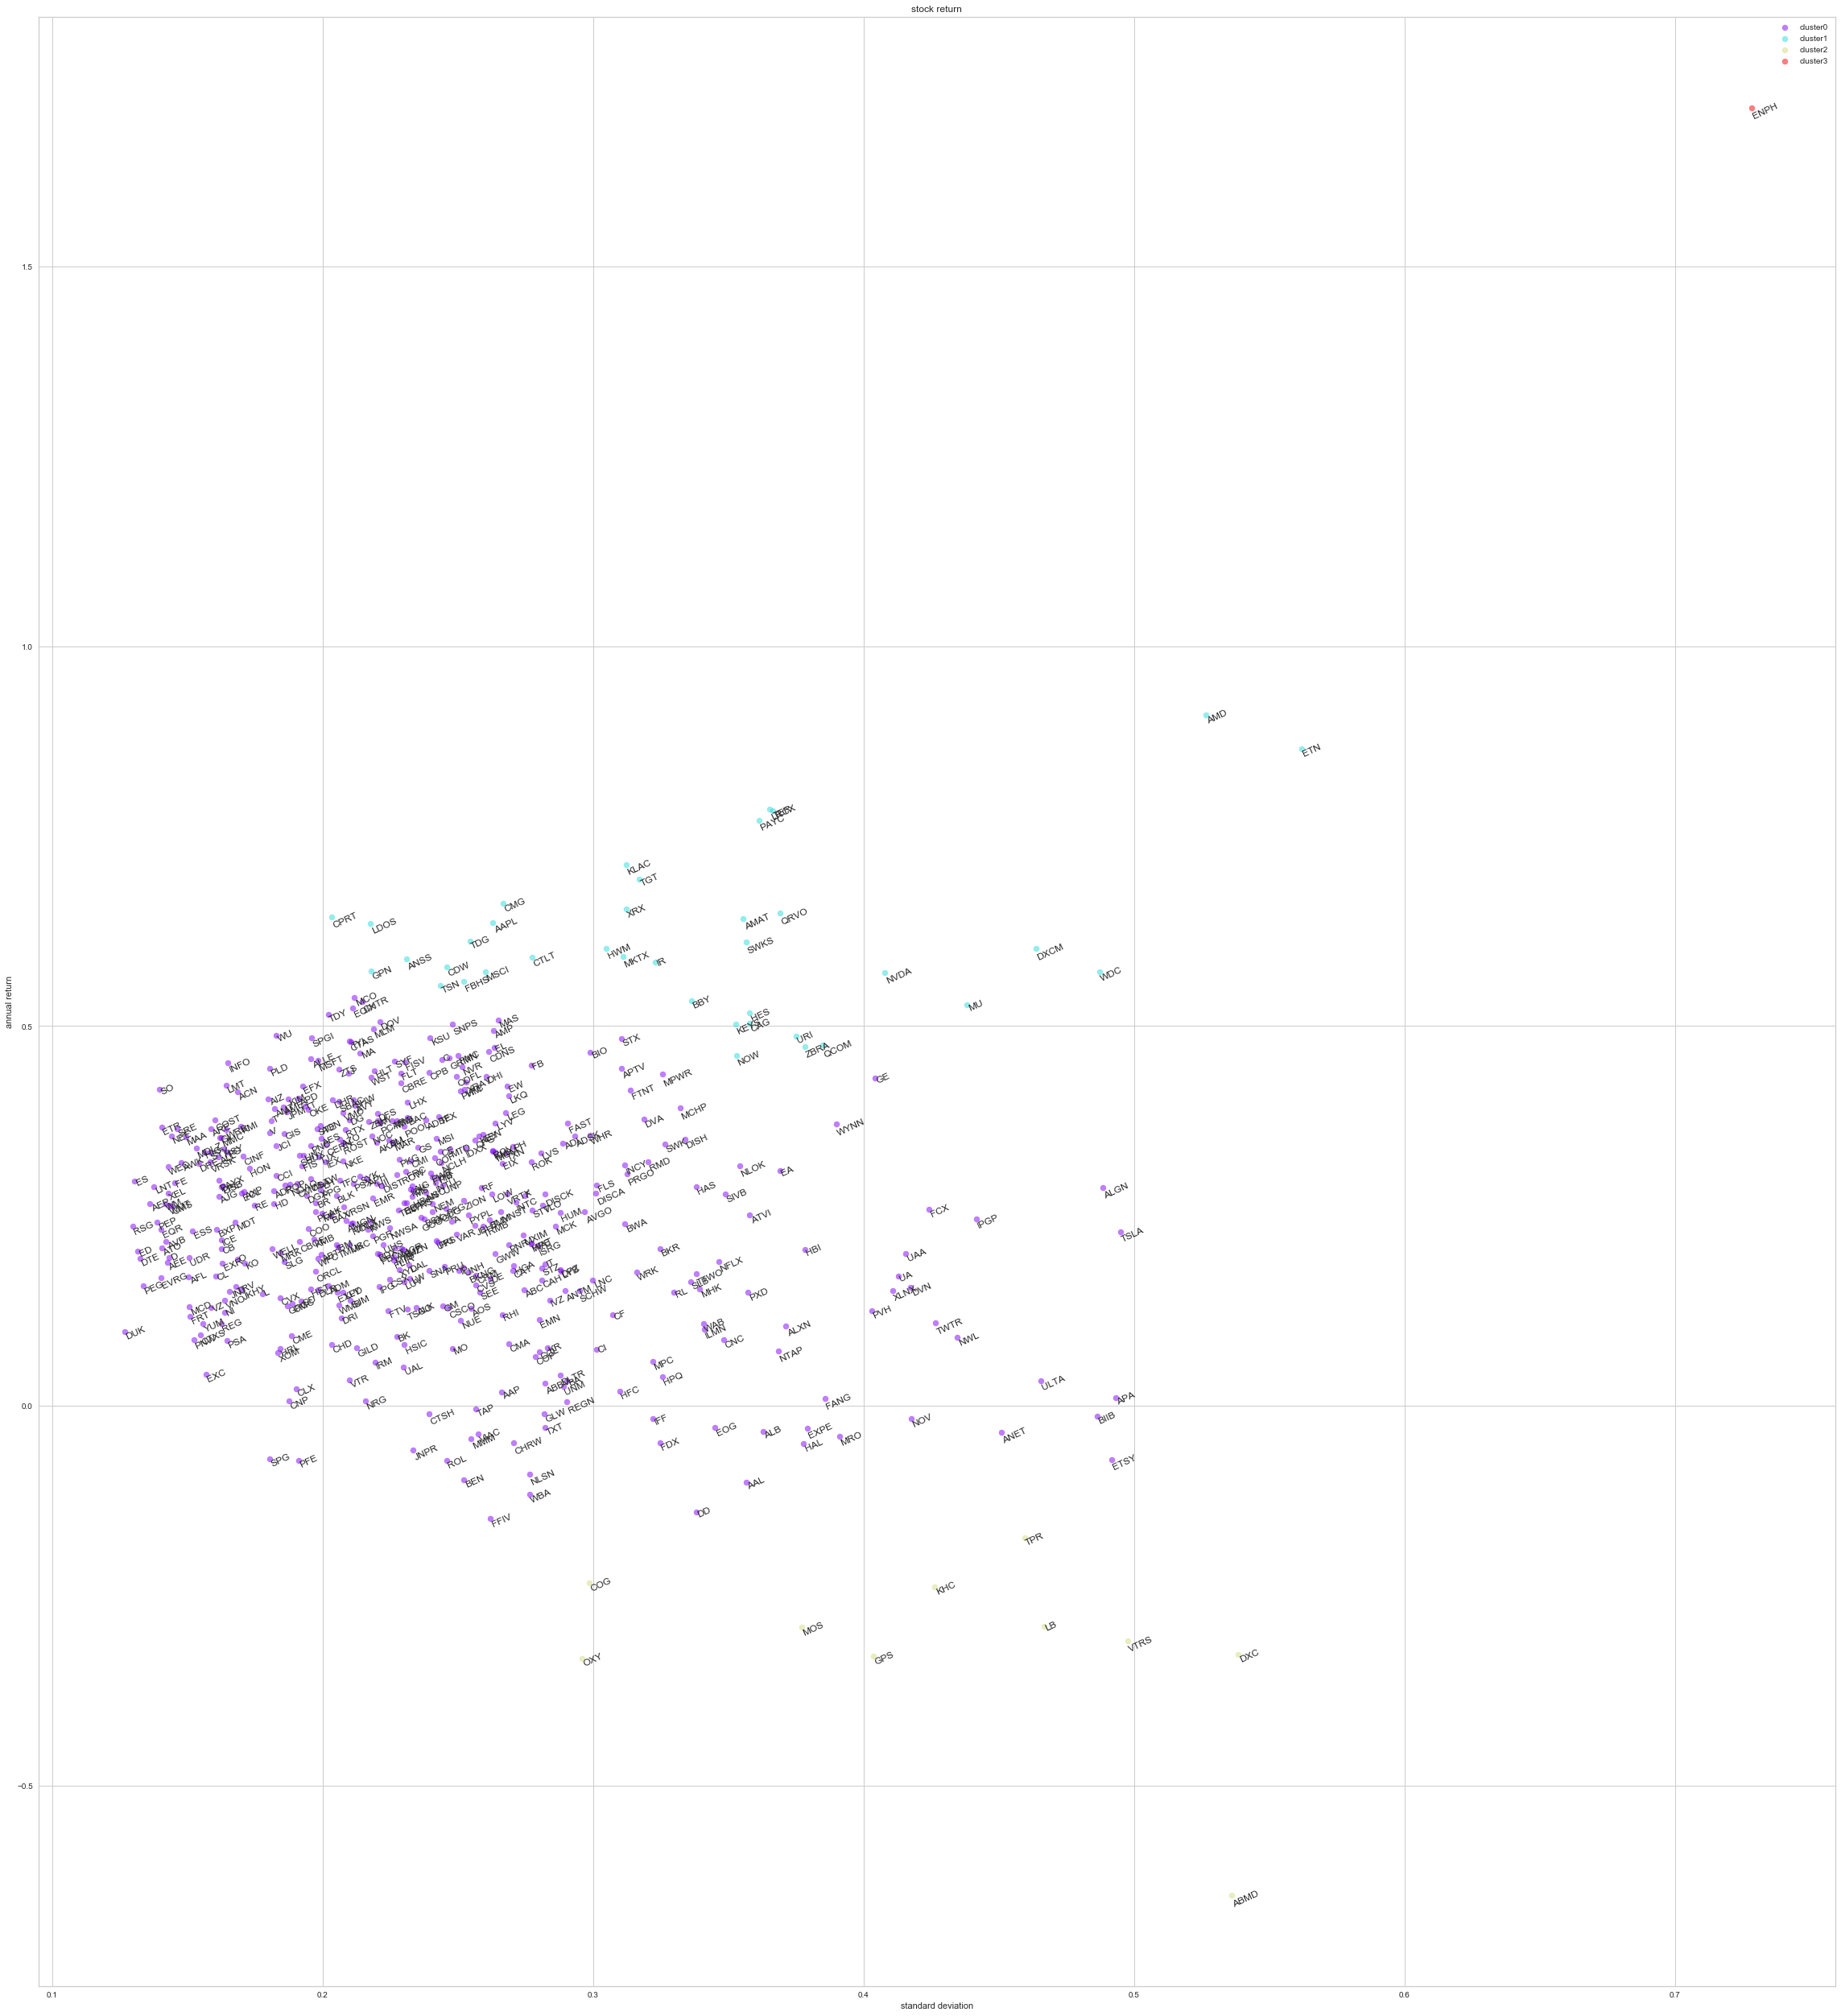

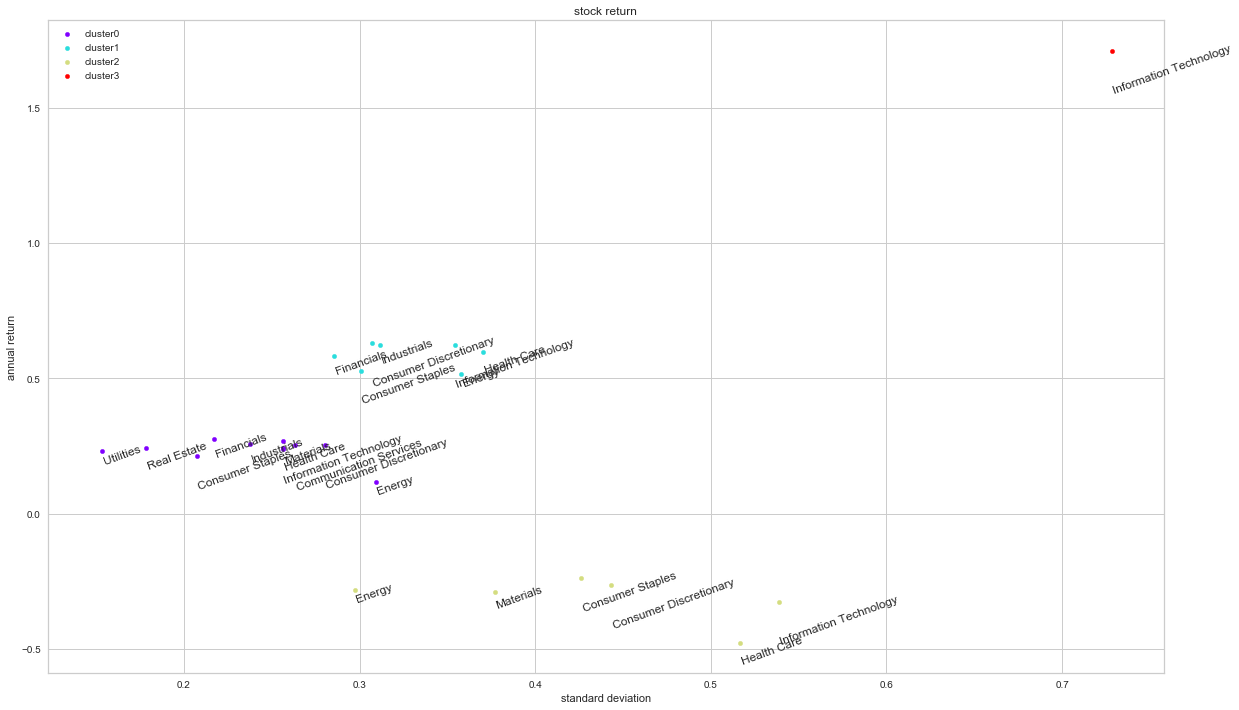

In [134]:
######## Part 2.1: agglomerative clustering
dist_matrix = distance_matrix(feature500_mtx,feature500_mtx) 
agglom = AgglomerativeClustering(n_clusters = 4, linkage = 'complete')
agglom.fit(feature500_mtx)
agglom.labels_
dataset['cluster_'] = agglom.labels_ 
dataset.head()

import matplotlib.cm as cm
n_clusters = max(agglom.labels_)+1
colors = cm.rainbow(np.linspace(0, 1, n_clusters))
cluster_labels = list(range(0, n_clusters))
plt.figure(figsize=(40,45))

for color, label in zip(colors, cluster_labels):
    subset = dataset[dataset.cluster_ == label]
    for i in subset.index:
            plt.text(subset.Std[i], subset.annual_return_log[i], str(subset['Company'][i]), rotation=25) 
    plt.scatter(subset.Std, subset.annual_return_log, s= 50, c=color, label='cluster'+str(label),alpha=0.5)

plt.legend()
plt.title('stock return')
plt.xlabel('standard deviation')
plt.ylabel('annual return')


#%%
####### Part 2.2: agglomerative clustering by industry

df2= dataset.groupby(['cluster_', 'sector'])['annual_return_log', 'Std' ].mean()


plt.figure(figsize=(20,12))
for color, label in zip(colors, cluster_labels):
    subset = df2.loc[(label,),]
    for i in subset.index:
        plt.text(subset.loc[i][1], subset.loc[i][0], str(i), rotation=20)
    plt.scatter(subset.Std, subset.annual_return_log, s=20, c=color, label='cluster'+str(label))
plt.legend()
plt.title('stock return')
plt.xlabel('standard deviation')
plt.ylabel('annual return')

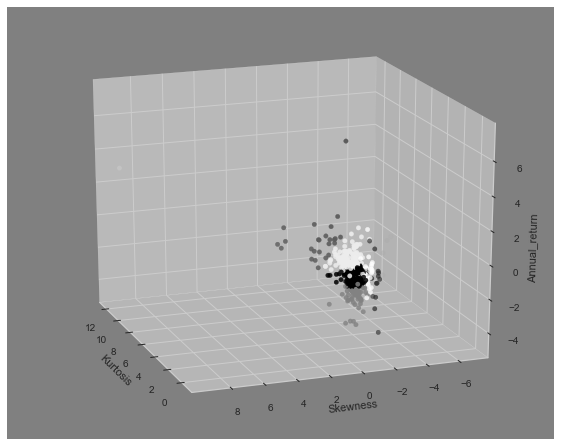

In [127]:
#### Part 3: K-mean 3D
feature = dataset[['annual_return_log','Skewness','Kurtosis']]
feature_mtx2 = feature.values

#%%
#Normalisation
from sklearn.preprocessing import StandardScaler
feature_mtx2 = StandardScaler().fit_transform(feature_mtx2)

clusterNum = 8
k_means = KMeans(init = "k-means++", n_clusters = clusterNum, n_init = 12)
k_means.fit(feature_mtx2)
labels = k_means.labels_

fig = plt.figure(1, figsize=(8, 6))
plt.clf()
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=20, azim=160,fc='grey')
plt.cla()
ax.set_xlabel('Kurtosis')
ax.set_ylabel('Skewness')
ax.set_zlabel('Annual_return')

ax.scatter(feature_mtx2[:, 2], feature_mtx2[:, 1], feature_mtx2[:, 0], c= labels.astype(np.float))

